In [12]:
import numpy as np
from sklearn import metrics
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, datasets
import torchvision.transforms as transforms
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

In [13]:
print(f"Is GPU available? {torch.cuda.is_available()}")
print(f"Number of available devices: {torch.cuda.device_count()}")
print(f"Index of current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Is GPU available? True
Number of available devices: 1
Index of current device: 0
Device name: NVIDIA GeForce GTX 1650 with Max-Q Design


In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#defaults
#might delete later
BATCH_SIZE = 128
N_EPOCHS = 10
LEARNING_RATE = 0.001

# Importing classes

In [16]:
!jupyter nbconvert --to python notMNIST_networks.ipynb

#The classes cannot be run from a jupyter notebook, this executes the script and converts it to a python script

from notMNIST_networks import MLP, CustomCNN


# Nacitanie dat

In [17]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

class notMNIST(Dataset):
    def __init__(self, data, labels):
        self.images = data
        self.labels = labels

        self.transformation = transforms.Compose([
                                                  
            transforms.ToTensor(),
            transforms.ConvertImageDtype(dtype=torch.float32),
        ])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]
        img_tensor = self.transformation(img)
        y_tensor = torch.tensor(label, dtype=torch.long)
        return img_tensor.view(1, 28, 28), y_tensor


data = loadmat('notMNIST_small.mat')
print(data.keys())

images = data['images']
labels = data['labels']

print(images.shape)
images = [images[:, :, i] for i in range(0, images.shape[2])]
images = np.asarray(images)
print(images.shape)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, shuffle=True)

train_dataset = notMNIST(x_train, y_train)
test_dataset = notMNIST(x_test, y_test)

trainloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dict_keys(['__header__', '__version__', '__globals__', 'images', 'labels'])
(28, 28, 18724)
(18724, 28, 28)


# Nacitanie modelu

In [18]:
PATH_MLP = "./model_mlp.pt"
PATH_CNN_1= "./model_cnn_1.pt"
PATH_CNN_2= "./model_cnn_2.pt"
PATH_CNN_resnet= "./model_cnn_resnet.pt"


model = None
model = MLP()
model.load_state_dict(torch.load(PATH_MLP))
print(model)

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Softmax(dim=None)
  )
)


# Nacitanie logov

*Vythianutie dat z logov ulozenych writerom, courtesy of chatgpt*

In [20]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# Specify the path to your SummaryWriter directory
log_dir = './runs/experiment_MLP'

#Read the latest log
# Get a list of event files (logs) in the directory
event_files = [os.path.join(log_dir, file) for file in os.listdir(log_dir) if file.startswith('events.out.tfevents.')]
#sort by timestamp
event_files.sort(key=os.path.getmtime, reverse=True)
#get the latest
latest_event_file = event_files[0]

# Create an EventAccumulator for the specified log directory
event_acc = EventAccumulator(latest_event_file)

# Load the event data
event_acc.Reload()

# Get a list of available tags (scalar summaries)
scalar_tags = event_acc.Tags()['scalars']

# Read the data for a specific tag (e.g., 'training accuracy')
tag_to_read = 'training accuracy'
acc_history=[]
n_epochs = 0

if tag_to_read in scalar_tags:
    # Get the events associated with the tag
    events = event_acc.Scalars(tag_to_read)

    # Extract the values and steps (epochs in this case)
    values = [event.value for event in events]
    steps = [event.step for event in events]

    # Now, 'values' contains the recorded accuracy values, and 'steps' contains the corresponding epoch numbers
    for step, value in zip(steps, values):
        print(f"Epoch {step}: Accuracy = {value}")
        acc_history.append(value)
        n_epochs=n_epochs+1
else:
    print(f"Tag '{tag_to_read}' not found in scalar summaries.")
    
# Read the data for a specific tag (e.g., 'training accuracy')
tag_to_read = 'training loss'
loss_history=[]

if tag_to_read in scalar_tags:
    # Get the events associated with the tag
    events = event_acc.Scalars(tag_to_read)

    # Extract the values and steps (epochs in this case)
    values = [event.value for event in events]
    steps = [event.step for event in events]

    # Now, 'values' contains the recorded accuracy values, and 'steps' contains the corresponding epoch numbers
    for step, value in zip(steps, values):
        print(f"Epoch {step}: Loss = {value}")
        loss_history.append(value)
else:
    print(f"Tag '{tag_to_read}' not found in scalar summaries.")
    
    


Epoch 1: Accuracy = 0.42789745330810547
Epoch 2: Accuracy = 0.4700908064842224
Epoch 3: Accuracy = 0.4706248939037323
Epoch 4: Accuracy = 0.47632187604904175
Epoch 5: Accuracy = 0.43047890067100525
Epoch 6: Accuracy = 0.5011572241783142
Epoch 7: Accuracy = 0.47258323431015015
Epoch 8: Accuracy = 0.43813422322273254
Epoch 9: Accuracy = 0.44374221563339233
Epoch 10: Accuracy = 0.4741854965686798
Epoch 1: Loss = 2.055443048477173
Epoch 2: Loss = 2.0132572650909424
Epoch 3: Loss = 2.0127997398376465
Epoch 4: Loss = 2.00738263130188
Epoch 5: Loss = 2.053257942199707
Epoch 6: Loss = 1.9821873903274536
Epoch 7: Loss = 2.0112502574920654
Epoch 8: Loss = 2.045938730239868
Epoch 9: Loss = 2.040604829788208
Epoch 10: Loss = 2.0096044540405273


# Testovacia funkcia

In [21]:
def testing_function(model, testloader, final_predicted, final_labels):
    model.eval()  # activate evaulation mode, some layers behave differently
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model.cuda()
    total = 0
    correct = 0

    for inputs, labels in tqdm(iter(testloader), desc="Full forward pass", total=len(testloader)):
        if use_cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
        with torch.no_grad():
            outputs_batch = model(inputs)

        _, predicted = torch.max(outputs_batch.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        final_predicted += predicted.tolist()
        final_labels += labels.tolist()
    print('Accuracy of the network on the test images: %0.2f %%' % (100 * correct / total))

# Testovanie modelu

In [22]:
final_labels = []
final_predicted = []

testing_function(model,testloader,final_labels,final_predicted)

Full forward pass:   0%|          | 0/59 [00:00<?, ?it/s]

C:\Users\micha\AppData\Roaming\Python\Python310\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of the network on the test images: 48.38 %


# Outputting logs


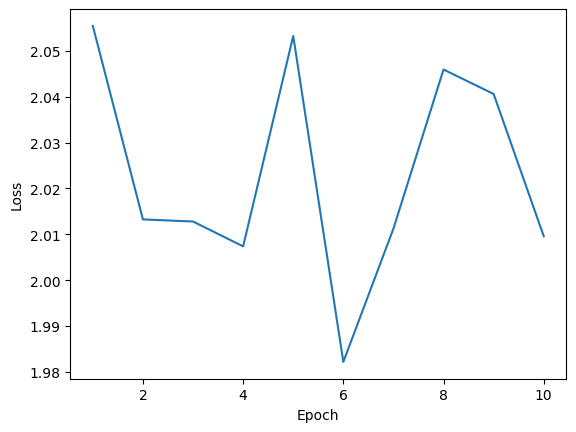

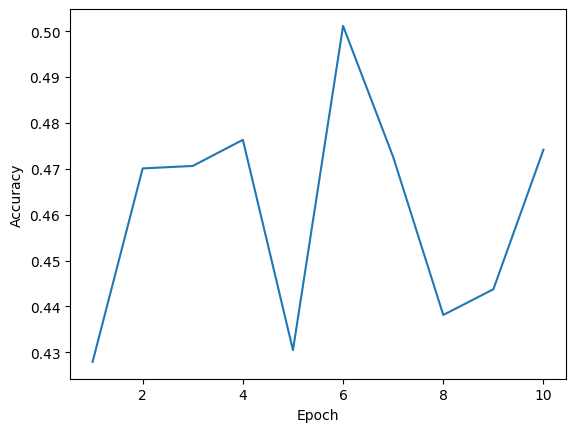

In [23]:
plt.plot(np.array(range(1, n_epochs + 1)), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(np.array(range(1, n_epochs + 1)), acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

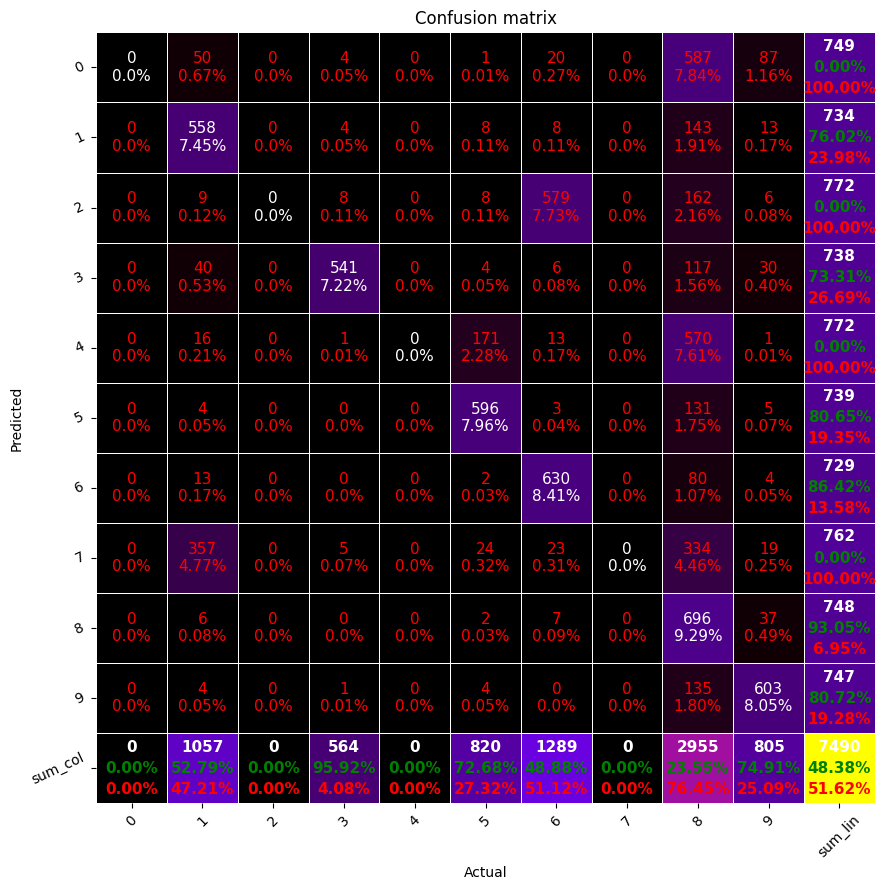

In [24]:
import numpy as np
from pretty_confusion_matrix import pp_matrix_from_data

y_test = final_labels
predic =  final_predicted

labels = [i for i in range(10)]

pp_matrix_from_data(y_test, predic, columns=labels, cmap="gnuplot")